# Fetching Clusters

In [1]:
import numpy as np
import pandas as pd
import math
import re
import kneed
import ast
from functools import lru_cache
from copy import deepcopy

In [2]:
def clusterStringToIndexList(clusterString):
    """
    Converts (1,(2,3),(4,5)) -> [1,2,3,4,5]
    """
    return [int(x) for x in re.findall('(\d+)',clusterString)]

In [3]:
def aggloClusterAverage(numberOfClusters, numTS = 157, verbose = False, measurement = 'shape', distancePriority = 'min'):
    """
    Performs agglomerative hierarchial clustering - distance between clusters is calculated
    as the average distance of every combination of time series within the clusters. I.E.
    given cluster (A,B) and cluster (C,D), the distance between them is calculated as:
    
            (dist(A,C) + dist(A,D) + dist(B,C) + dist(B,D)) / (2 * 2)
            
    Parameters:
        numberOfClusters: the number of clusters to generate
        numTS: the number of time series to be clustered
        verbose: Boolean set to whether the algorithm prints the clusters as they are formed
        measurement: Specifies wich distance matrix to use based on the distance measurement
    """
    
    representativeList = [x for x in range(numTS)]
    distanceList = [0 for x in range(numTS)]
    lengthsList = [1 for x in range(numTS)]
    clusterVariances = []
    silhouetteCoefficients = []
    
    # begins with each time series in their own cluster, and combining until
    # the desired number of clusters is reached
    while len(representativeList) != numberOfClusters:
        if distancePriority == 'min':
            optDist = math.inf
        else:
            optDist = -math.inf
        optDisti = -1
        optDistj = -1
        for i in range(len(representativeList)):
            for j in range(i + 1, len(representativeList)):
                clusterStringi = str(representativeList[i])
                clusterStringj = str(representativeList[j])
                
                # Calculating distance between two clusters using defined measurement method
                distance = betweenClusterDist(clusterStringi, clusterStringj, measurement = measurement)
                
                # Keeping track of min/max distance of examined cluster combos
                if (distancePriority == 'min' and distance < optDist) or (distancePriority != 'min' and distance > optDist): 
                    optDist = distance
                    optDisti = i; optDistj = j
        
        if verbose:
            #print((representativeList[optDisti], representativeList[optDistj]))
            print("{} Clusters distance: {}".format(len(representativeList), optDist))
        
        # Messy but it works and speed is not an issue. Each list is parallel to the other
        # --------------------------------------------------------------------------------
        
        # RepresentativeList is used to keep track of the actual cluster strings
        representativeList.append((representativeList[optDisti], representativeList[optDistj]))
        representativeList.pop(optDistj)
        representativeList.pop(optDisti)
        
        # lengthsList is used to keep track of how many time series exist in
        # a cluster such that the average error can be weighted accordingly
        lengthsList.append(lengthsList[optDistj] + lengthsList[optDisti])
        lengthsList.pop(optDistj)
        lengthsList.pop(optDisti)
        
        # distanceList is used to keep track of the within-cluster error
        distanceList.append(optDist)
        distanceList.pop(optDistj)
        distanceList.pop(optDisti)
        
        # Using each of the three lists to calculate the average error of all clusters,
        # weighted for how many time series are within each cluster. I.E. given two clusters,
        # A with 15 time series and error = 20, and B with 5 time series and error = 0, the 
        # average error is 15 because (20 * 0.75) + (0 * 0.25) = 15
        clusterVariance = 0
        for i in range(len(lengthsList)):
            proportionTotalTS = lengthsList[i] / numTS
            clusterVariance += proportionTotalTS * distanceList[i]
        
        # Used for plotting the change in error as the number of clusters changes
        clusterVariances.insert(0, clusterVariance)
        
        # Calculating Silhoette Coefficient for the current clustering
        if len(representativeList) == 1:
            silhouetteCoefficients.insert(0, 0)
        else:
            silhouetteCoefficients.insert(0, silhouetteCoefficient(representativeList, method = measurement))
        
    return representativeList, distanceList, clusterVariances, silhouetteCoefficients

In [4]:
@lru_cache(maxsize=1024)
def betweenClusterDist(clusterStringi, clusterStringj, measurement = 'raw'):
    """
    Calculates the distance between two provided clusters using absolute linkage
    and the sliding window euclidean measurement.
    Parameters:
    
        clusterStringi: string representation of the first cluster
        clusterStringj:                              second
            
            ex) (1,(2,3),((4,5),6))
            
        measurement: Specifies which form of time series to cluster on
            'shape'     : normalizes every time series locally 
                          (each time series has range of 0 to 1) 
                          so the actual number of cases is not 
                          considered, just the trends.
            'raw'       : uses the raw data, relying entirely on the actual
                          number of cases divided by population
            'shape&raw' : uses both the raw values and shape to assess distance.
                          raw data is normalized on entire dataset, to which that
                          value and the 'shape' value are averaged.
            'rank'      : uses the ranked list
    """
    clusterListi = clusterStringToIndexList(clusterStringi)
    clusterListj = clusterStringToIndexList(clusterStringj)
    
    totalDist = 0
    for itemi in clusterListi:
        for itemj in clusterListj:
            if measurement == 'shape':
                totalDist += distMatrixShape[itemi][itemj]
            elif measurement == 'shape&raw':
                totalDist += distMatrixSizeShape[itemi][itemj]
            elif measurement == 'raw':
                totalDist += distMatrixRaw[itemi][itemj]
            else:
                totalDist += distMatrixRanked[itemi][itemj]
            
    distance = totalDist / (len(clusterListi) * len(clusterListj))
    return distance

In [5]:
# Importing Distance Matrices
distMatrixRawDF = pd.read_csv('Data//distance_matrix.csv', index_col=0)
distMatrixRaw = distMatrixRawDF.values.tolist()

distMatrixShapeDF = pd.read_csv('Data//distance_matrix_normalized.csv', index_col=0)
distMatrixShape = distMatrixShapeDF.values.tolist()

distMatrixRankedDF = pd.read_csv('Data//distance_matrix_ranked_normalized.csv', index_col=0)
distMatrixRanked = distMatrixRankedDF.values.tolist()

distMatrixMinRankedDF = pd.read_csv('Data//distance_matrix_min_ranked_normalized.csv', index_col=0)
distMatrixMinRankedDF = distMatrixMinRankedDF.drop(['Tanzania', 'Tajikistan'], axis = 0)
distMatrixMinRankedDF = distMatrixMinRankedDF.drop(['Tanzania', 'Tajikistan'], axis = 1)
distMatrixMinRanked = distMatrixMinRankedDF.values.tolist()

distMatrixNormalizedGlobalDF = pd.read_csv('Data//distance_matrix_normalized_global.csv', index_col=0)
distMatrixNormalizedGlobal = distMatrixNormalizedGlobalDF.values.tolist()
distMatrixSizeShape = [[0 for y in range(len(distMatrixRaw))] for x in range(len(distMatrixRaw))]
for i in range(len(distMatrixRaw)):
    for j in range(len(distMatrixRaw)):
        distMatrixSizeShape[i][j] = (distMatrixNormalizedGlobal[i][j] + distMatrixShape[i][j]) / 2

In [6]:
def listClusterCountries(clusters, countries):
    """
    Provided a cluster string, this method prints the set of countries contained within each cluster.
    Parameters:
        clusterString: cluster results. list -> (each element is a single cluster)
        countries: list of countries that maps a provided index from the
                   cluster string to the name of the country.
    """
    for i in range(len(clusters)):
        print("Cluster {}:\n---------\n".format(i + 1))
        for country in clusterStringToIndexList(str(clusters[i])):
            print(countries[country], end = ', ')
        print('\n')

**Silhouette Coefficient:**

In [7]:
def singleSilhouetteScore(i, intraCluster, interClusters, dm):
    """
    Calculates the silhouette score for a single sample using the formula:
    
                            (b-a) / max(a,b)
                            
    Where:
        a = the average intra-cluster distance for i
        b = the average inter-cluster distance between i and the cluster
            that i is closest to
    
    Parameters:
        i = the sample for which a score is being generated
        intraCluste = the cluster of samples that exist in the same cluster as i
        interCluster = the list of clusters that i does not belong to
        dm = the distance matrix used
    """
    
    # Checking if i belongs to a solo cluster
    if type(intraCluster) == int:
        return 0
    
    a = intraClusterDist(i, intraCluster, dm)
    b = interClusterDist(i, interClusters, dm)
    
    return (b-a) / max(a,b)
        
def intraClusterDist(i, cluster, dm):
    totalDist = 0
    clusterList = clusterStringToIndexList(str(cluster))
    for sample in clusterList:
        if sample != i:
            totalDist += dm[i][sample]
    return totalDist / (len(clusterList)-1)

def interClusterDist(i, clusters, dm):
    minDist = math.inf
    for cluster in clusters:
        totalDist = 0
        clusterList = clusterStringToIndexList(str(cluster))
        for sample in clusterList:
            totalDist += dm[i][sample]
        avgDist = totalDist / len(clusterList)
        if avgDist < minDist:
            minDist = avgDist
    return minDist

In [8]:
def clusterSilhouetteScore(clustering, cluster, dm):
    """
    Calculates silhoette score for the given cluster as the average silhouette score
    of all samples within the cluster
    
    Parameters:
        clustering: cluster generated by our agglomerative
                    hierarchical clustering method
        cluster:    individual cluster that the score is to
                    be generated for
        dm:         The distance matrix used
    """
    
    totalSS = 0
    clusterSamples = clusterStringToIndexList(str(cluster))
    for sample in clusterSamples:
        totalSS += singleSilhouetteScore(sample, cluster, clustering, dm)
    return totalSS / len(clusterSamples)

In [9]:
def silhouetteCoefficient(clustering, method = 'raw'):
    """
    Calculates the silhouette score for the entire clustering.
    
    Parameters:
        clustering: cluster generated by our agglomerative
                    hierarchical clustering method
        measurement: Specifies which form of time series to cluster on
                'shape'     : normalizes every time series locally 
                              (each time series has range of 0 to 1) 
                              so the actual number of cases is not 
                              considered, just the trends.
                'raw'       : uses the raw data, relying entirely on the actual
                              number of cases divided by population
                'shape&raw' : uses both the raw values and shape to assess distance.
                              raw data is normalized on entire dataset, to which that
                              value and the 'shape' value are averaged.
                'rank'      : uses depth ranked values
                'min'       : uses min ranked values
    """
    
    # Selecting distance matrix to use
    if method == 'raw':
        dm = distMatrixRaw
    elif method == 'shape':
        dm = distMatrixShape
    elif method == 'shape&raw':
        dm = distMatrixSizeShape
    elif method == 'rank':
        dm = distMatrixRanked
    else:
        dm = distMatrixMinRanked
        
    maxSS = -math.inf
    for cluster in clustering:
        clusteringCopy = deepcopy(clustering)
        clusteringCopy.remove(cluster)
        clusterSS = clusterSilhouetteScore(clusteringCopy, cluster, dm)
        if clusterSS > maxSS:
            maxSS = clusterSS
            
    return maxSS 

### Results

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

In [11]:
def normalizeList(l):
    maxVal = max(l)
    minVal = min(l)
    for i in range(len(l)):
        l[i] = (l[i] - minVal) / (maxVal - minVal)
    return l

In [12]:
countries = list(distMatrixRawDF.columns)

countriesMinRank = [country for country in countries]
countriesMinRank.pop(countriesMinRank.index('Tanzania'))
countriesMinRank.pop(countriesMinRank.index('Tajikistan'))

'Tajikistan'

In [126]:
betweenClusterDist.cache_clear()

#Specify the desired number of clusters as the first parameter
clusterRaw, distancesRaw, clusterVariancesRaw, silhouetteCoefficientsRaw = aggloClusterAverage(1, measurement = 'raw')

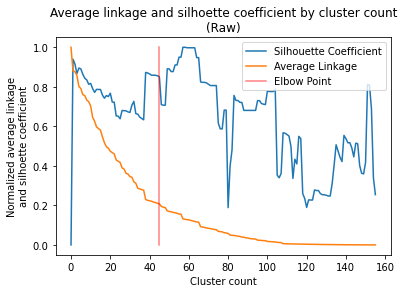

In [160]:
plt.plot([x for x in range(len(silhouetteCoefficientsRaw))], normalizeList(silhouetteCoefficientsRaw.copy()))
plt.plot([x for x in range(len(clusterVariancesRaw))], normalizeList(clusterVariancesRaw.copy()))
plt.plot([45,45],[0,1],color='red',alpha = 0.5)
plt.title("Average linkage and silhoette coefficient by cluster count\n(Raw)")
plt.xlabel("Cluster count")
plt.ylabel("Normalized average linkage\nand silhoette coefficient")
plt.legend(['Silhouette Coefficient','Average Linkage','Elbow Point'], loc = 'upper right')
plt.savefig('raw.png')

In [128]:
betweenClusterDist.cache_clear()

#Specify the desired number of clusters as the first parameter
clusterShape, distancesShape, clusterVariancesShape, silhouetteCoefficientsShape = aggloClusterAverage(1, measurement = 'shape')

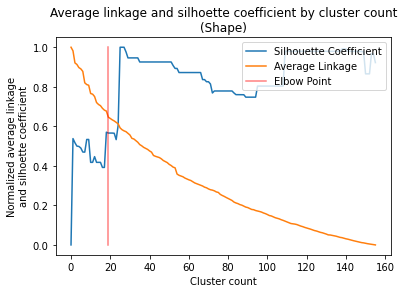

In [161]:
plt.plot([x for x in range(len(silhouetteCoefficientsShape))], normalizeList(silhouetteCoefficientsShape.copy()))
plt.plot([x for x in range(len(clusterVariancesShape))], normalizeList(clusterVariancesShape.copy()))
plt.plot([19,19],[0,1],color='red',alpha = 0.5)
plt.title("Average linkage and silhoette coefficient by cluster count\n(Shape)")
plt.xlabel("Cluster count")
plt.ylabel("Normalized average linkage\nand silhoette coefficient")
plt.legend(['Silhouette Coefficient','Average Linkage','Elbow Point'], loc = 'upper right')
plt.savefig('shape.png')

In [130]:
betweenClusterDist.cache_clear()

#Specify the desired number of clusters as the first parameter
clusterShapeRaw, distancesShapeRaw, clusterVariancesShapeRaw, silhouetteCoefficientsShapeRaw = aggloClusterAverage(1, measurement = 'shape&raw')

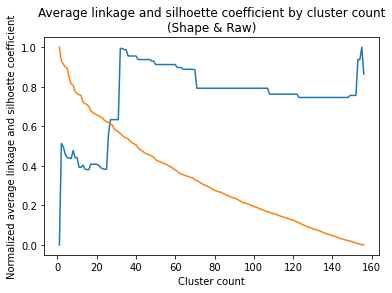

In [131]:
plt.plot([x + 1 for x in range(len(silhouetteCoefficientsShapeRaw))], normalizeList(silhouetteCoefficientsShapeRaw.copy()))
plt.plot([x + 1 for x in range(len(clusterVariancesShapeRaw))], normalizeList(clusterVariancesShapeRaw.copy()))
plt.title("Average linkage and silhoette coefficient by cluster count\n(Shape & Raw)")
plt.xlabel("Cluster count")
plt.ylabel("Normalized average linkage and silhoette coefficient")
plt.show()

In [132]:
betweenClusterDist.cache_clear()

#Specify the desired number of clusters as the first parameter
clusterShapeRanked, distancesShapeRanked, clusterVariancesShapeRanked, silhouetteCoefficientsShapeRanked = aggloClusterAverage(1, measurement = 'rank')

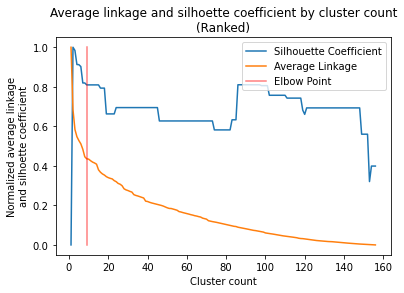

In [162]:
plt.plot([x + 1 for x in range(len(silhouetteCoefficientsShapeRanked))], normalizeList(silhouetteCoefficientsShapeRanked.copy()))
plt.plot([x + 1 for x in range(len(clusterVariancesShapeRanked))], normalizeList(clusterVariancesShapeRanked.copy()))
plt.plot([9,9],[0,1],color='red',alpha = 0.5)
plt.title("Average linkage and silhoette coefficient by cluster count\n(Ranked)")
plt.xlabel("Cluster count")
plt.ylabel("Normalized average linkage\nand silhoette coefficient")
plt.legend(['Silhouette Coefficient','Average Linkage','Elbow Point'], loc = 'upper right')
plt.savefig('rank.png')

In [134]:
betweenClusterDist.cache_clear()

#Specify the desired number of clusters as the first parameter
clusterMinRanked, distancesMinRanked, clusterVariancesMinRanked, silhouetteCoefficientsMinRanked = aggloClusterAverage(1, numTS = 155, measurement = 'min')

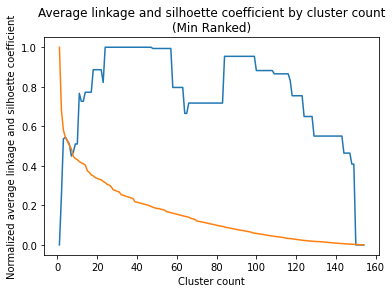

In [135]:
plt.plot([x + 1 for x in range(len(silhouetteCoefficientsMinRanked))], normalizeList(silhouetteCoefficientsMinRanked.copy()))
plt.plot([x + 1 for x in range(len(clusterVariancesMinRanked))], normalizeList(clusterVariancesMinRanked.copy()))
plt.title("Average linkage and silhoette coefficient by cluster count\n(Min Ranked)")
plt.xlabel("Cluster count")
plt.ylabel("Normalized average linkage and silhoette coefficient")
plt.show()

Text(0.5, 1.0, 'Non-Normalized Time Series Dendrogram')

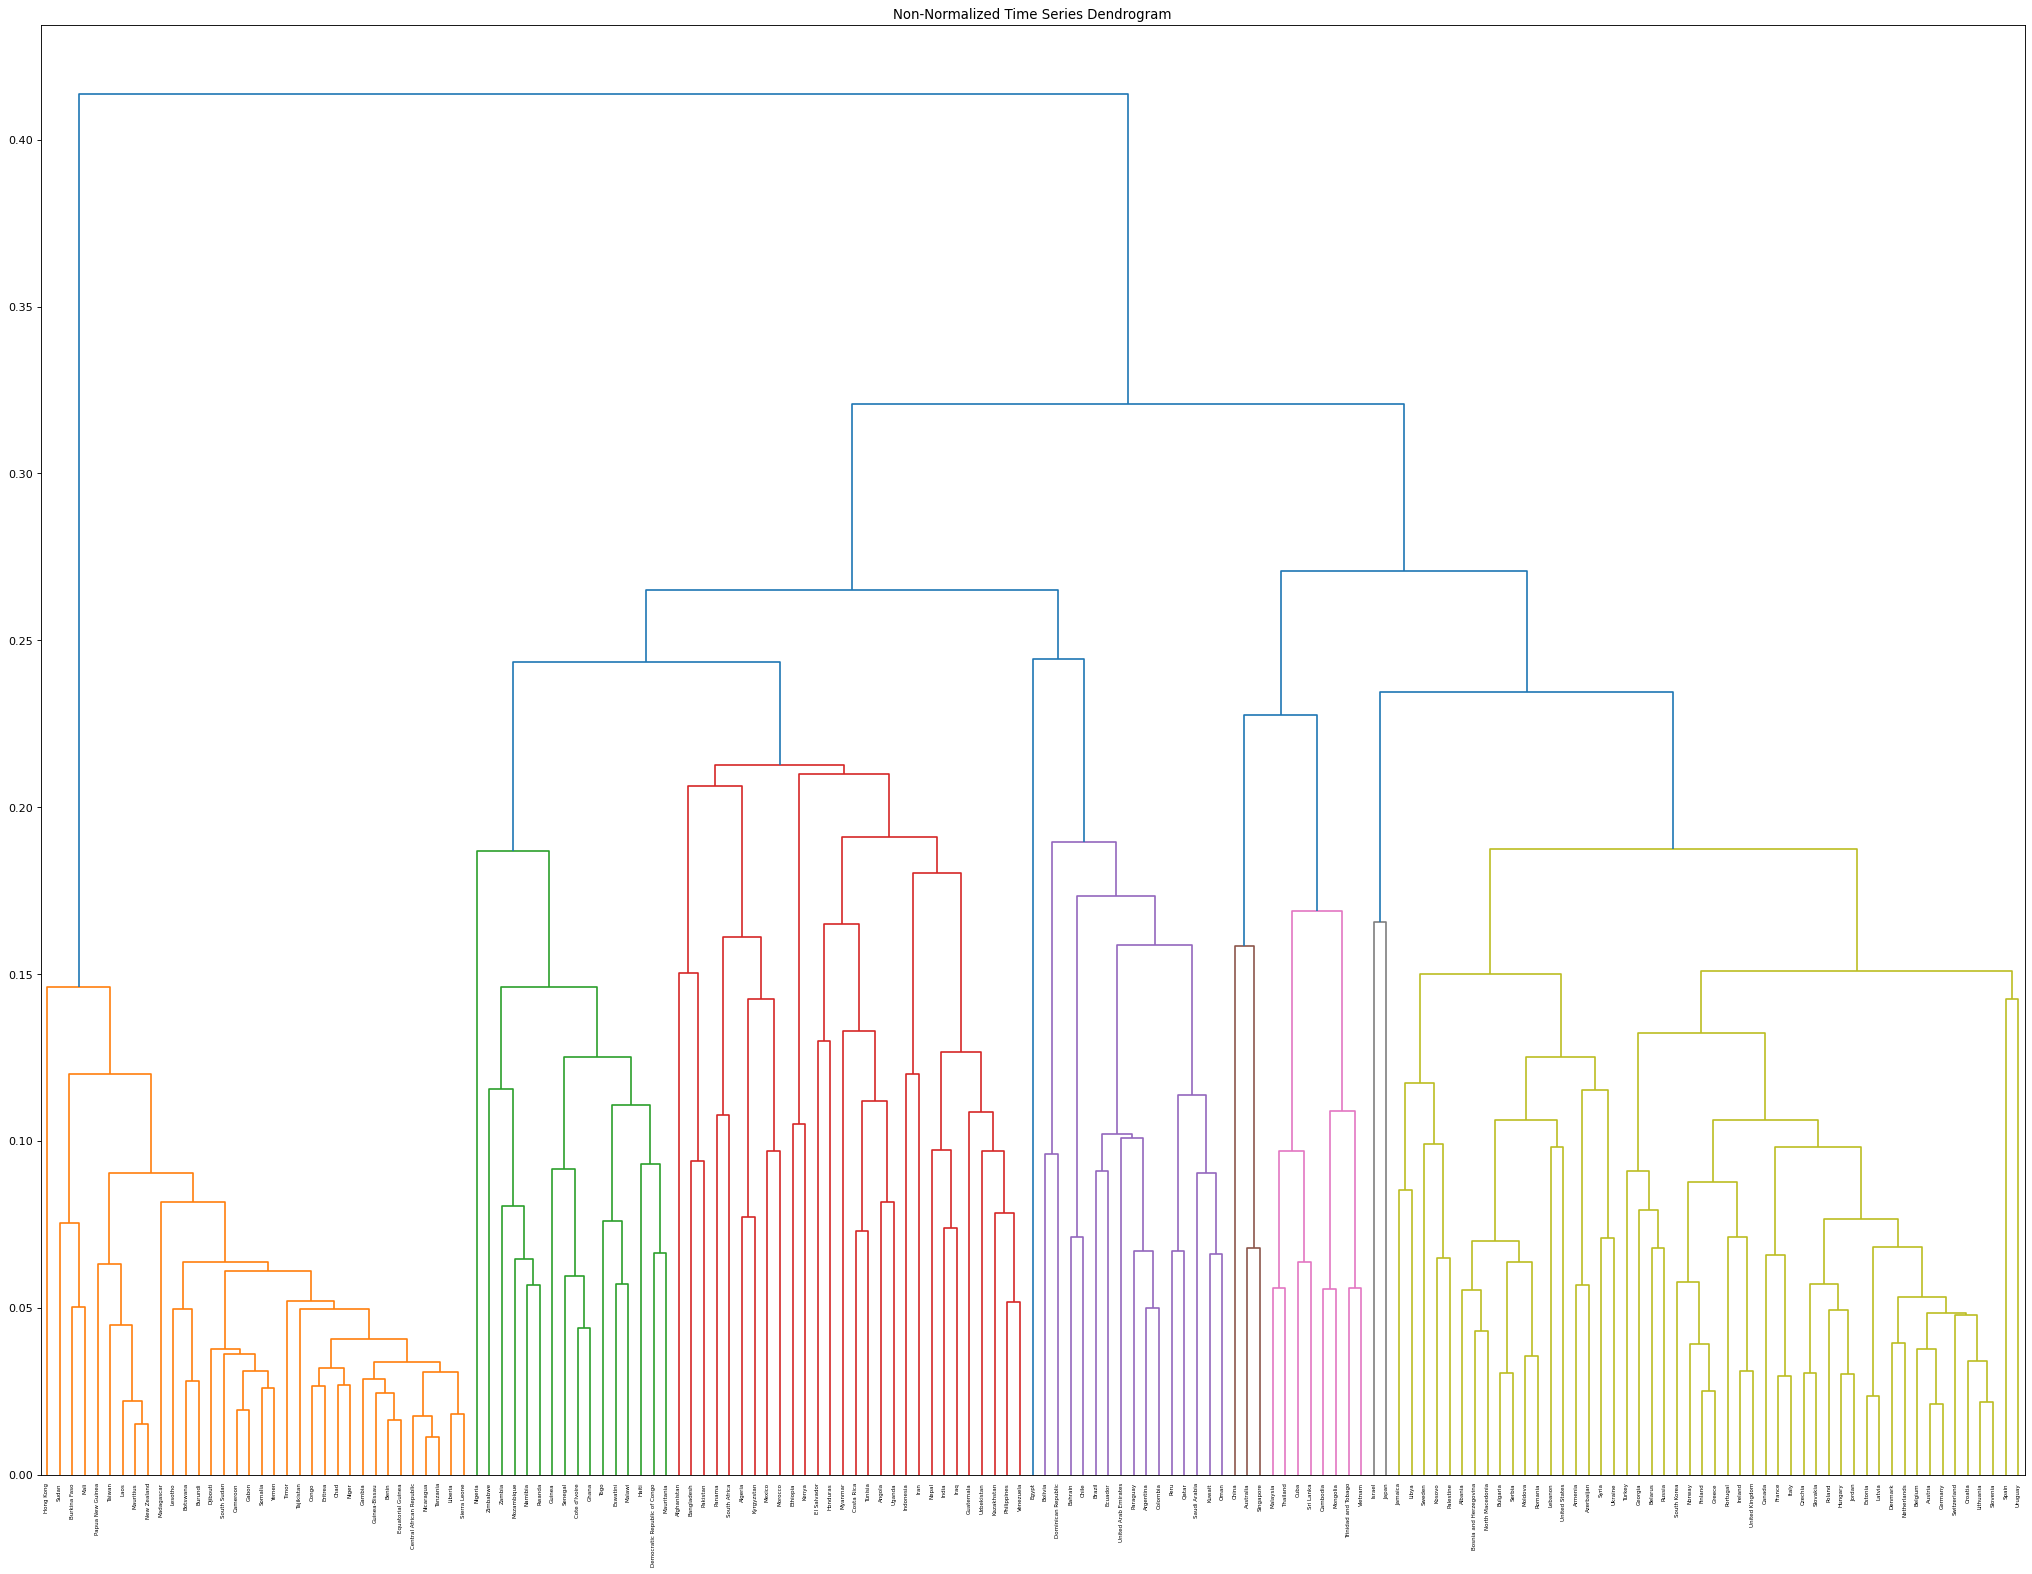

In [23]:
plt.figure(figsize=(32, 24), dpi=80)
dists = squareform(distMatrixRanked)
linkage_matrix = linkage(dists, "average")
dendrogram(linkage_matrix, labels=countries, color_threshold=0.22)
plt.title("Non-Normalized Time Series Dendrogram")

In [25]:
def optimalCluster(SCList, ALList, normalize = True, s = 1.0):
    """
    Finds the optimal cluster count provided the silhouette coefficients and average linkage
    
    Parameters:
        SCList: list of silhouette coefficients
        ALList: list of average linkage scores
    """
    
    maxScore = -math.inf
    maxScoreIndex = -1
    
    if normalize:
        ALL = normalizeList(ALList.copy())
        SCL = normalizeList(SCList.copy())
    else:
        ALL = ALList.copy()
        SCL = SCList.copy()
    
    kneedle = kneed.KneeLocator([x + 1 for x in range(len(ALL))], ALL, S=s, curve="convex", direction="decreasing")
    knee = kneedle.knee
    print("Knee: {}".format(knee))
    
    for i in range(1, len(SCL)):
        score = abs(SCL[i] - ALL[i]) * (((len(SCL) - abs(i - knee + 1)) / len(SCL))**2)
        if score > maxScore:
            maxScore = score
            maxScoreIndex = i + 1
            
    return maxScoreIndex

In [157]:
optimalCluster(silhouetteCoefficientsShapeRaw, clusterVariancesShapeRaw, s = 1)

Knee: 45


45

In [148]:
optimalCluster(silhouetteCoefficientsShape, clusterVariancesShape, s = 0.5)

Knee: 11


2

In [34]:
optimalCluster(silhouetteCoefficientsRaw, clusterVariancesRaw, s = 0.5)

Knee: 31


58

In [138]:
optimalCluster(silhouetteCoefficientsShapeRanked, clusterVariancesShapeRanked, s = 0.5)

Knee: 9


15

In [36]:
optimalCluster(silhouetteCoefficientsMinRanked, clusterVariancesMinRanked, s = 0.5)

Knee: 19


24

In [37]:
def plotCluster(TSL, clusterString, yMin = -3, yMax = 3):
    group = clusterStringToIndexList(str(clusterString))
    for index in group:
        plt.plot([x for x in range(len(TSL[index]))], TSL[index], color = 'silver', alpha = 0.4)
    avgTS = averageTS([TSL[x] for x in group])
    plt.plot([x for x in range(len(avgTS))], avgTS, color = 'violet')
    plt.ylim(yMin, yMax)
    plt.show()
    
def averageTS(TSList):
    newTS = []
    for i in range(len(TSList[0])):
        newTS.append(sum([x[i] for x in TSList]) / len(TSList))
    return newTS

In [38]:
rankedNewCaseTimeSeries = []
with open('Data//denseRankedTS.txt', 'r') as fp:
    for line in fp:
        rankedNewCaseTimeSeries.append(ast.literal_eval(line))

In [58]:
betweenClusterDist.cache_clear()

#Specify the desired number of clusters as the first parameter
clusterShapeRanked, distancesShapeRanked, clusterVariancesShapeRanked, silhouetteCoefficientsShapeRanked = aggloClusterAverage(15, measurement = 'rank')

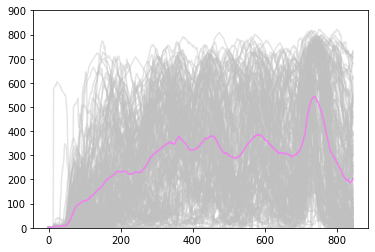

In [40]:
plotCluster(rankedNewCaseTimeSeries, clusterShapeRanked, yMin = 0, yMax = 900)

In [59]:
listClusterCountries(clusterShapeRanked, countries)

Cluster 1:
---------

Egypt, 

Cluster 2:
---------

Bolivia, Dominican Republic, 

Cluster 3:
---------

Ethiopia, Kenya, 

Cluster 4:
---------

Hong Kong, Sudan, Burkina Faso, Mali, Papua New Guinea, Taiwan, Laos, Mauritius, New Zealand, Madagascar, Lesotho, Botswana, Burundi, Djibouti, South Sudan, Cameroon, Gabon, Somalia, Yemen, Timor, Tajikistan, Congo, Eritrea, Chad, Niger, Gambia, Guinea-Bissau, Benin, Equatorial Guinea, Central African Republic, Nicaragua, Tanzania, Liberia, Sierra Leone, 

Cluster 5:
---------

Jamaica, Libya, Sweden, Kosovo, Palestine, Albania, Bosnia and Herzegovina, North Macedonia, Bulgaria, Serbia, Moldova, Romania, Lebanon, United States, Armenia, Azerbaijan, Syria, Ukraine, 

Cluster 6:
---------

Afghanistan, Bangladesh, Pakistan, 

Cluster 7:
---------

Turkey, Georgia, Belarus, Russia, South Korea, Norway, Finland, Greece, Portugal, Ireland, United Kingdom, Canada, France, Italy, Czechia, Slovakia, Poland, Hungary, Jordan, Estonia, Latvia, Denmark,

# Cluster Regressions

In [60]:
gdpDF = pd.read_csv('Data//gdpDF.csv', index_col=0)
gdpList = list(gdpDF.gdp_per_capita)

In [61]:
rankClusters = []
for cluster in clusterShapeRanked:
    rankClusters.append(clusterStringToIndexList(str(cluster)))

In [62]:
faultyDataCountries = [33, 126, 135, 136]

gdpClusters = []
for cluster in rankClusters:
    gdpCluster = []
    for country in cluster:
        if country not in faultyDataCountries:
            gdpCluster.append(gdpList[country])
    gdpClusters.append(gdpCluster)

In [63]:
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

In [64]:
tStatistics = [[0 for x in range(len(rankClusters))] for y in range(len(rankClusters))]
pValues = [[0 for x in range(len(rankClusters))] for y in range(len(rankClusters))]

for i in range(len(gdpClusters)):
    for j in range(i+1, len(gdpClusters)):
        t, p = ttest_ind(gdpClusters[i], gdpClusters[j], equal_var=False)
        tStatistics[i][j] = t; tStatistics[j][i] = t
        pValues[i][j] = p; pValues[j][i] = p

C:\Users\markr\Anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\markr\Anaconda3\envs\myenv\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning:

invalid value encountered in double_scalars



In [65]:
pd.DataFrame(tStatistics)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.000000,2.144318,0.777116,-1.184937,1.836601,-5.177299,-1.821591,-0.429791,0.807861,-5.224553,-0.806642,-2.735703,-0.213283,1.916598
2,NaN,2.144318,0.000000,-2.253477,-4.266405,-0.969708,-12.721789,-2.264503,-3.681102,-2.711342,-11.227286,-3.422008,-3.932411,-4.113105,-1.009330
3,NaN,0.777116,-2.253477,0.000000,-2.402059,1.677772,-8.389845,-2.011017,-1.570361,-0.001778,-7.950291,-1.827338,-3.283656,-1.438255,1.850559
4,NaN,-1.184937,-4.266405,-2.402059,0.000000,3.863766,-4.273271,-1.537623,0.924749,2.525960,-4.355425,0.354472,-2.152822,1.281034,4.004322
5,NaN,1.836601,-0.969708,1.677772,3.863766,0.000000,-11.852996,-2.209611,-3.202088,-1.980546,-10.589458,-3.074177,-3.796742,-3.475145,0.177746
6,NaN,-5.177299,-12.721789,-8.389845,-4.273271,-11.852996,0.000000,-0.689339,5.863747,9.066121,-0.447696,4.409870,-0.287696,6.940545,12.380207
7,NaN,-1.821591,-2.264503,-2.011017,-1.537623,-2.209611,-0.689339,0.000000,1.738001,2.014375,0.604169,1.617989,0.519288,1.797340,2.220682
8,NaN,-0.429791,-3.681102,-1.570361,0.924749,-3.202088,5.863747,1.738001,0.000000,1.676163,-5.780284,-0.490584,-2.629140,0.311107,3.368379
9,NaN,0.807861,-2.711342,-0.001778,2.525960,-1.980546,9.066121,2.014375,1.676163,0.000000,-8.446519,-1.908280,-3.313615,-1.569831,2.228466


In [66]:
pd.DataFrame(pValues)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.000000,2.676622e-01,5.312953e-01,0.323262,2.967517e-01,3.743888e-02,0.201737,0.706274,5.316521e-01,0.040078,0.476081,0.018311,8.536644e-01,2.964896e-01
2,NaN,0.267662,0.000000e+00,3.183232e-02,0.000532,4.038265e-01,7.784824e-14,0.151574,0.012195,3.027753e-02,0.046146,0.012974,0.001953,2.124886e-03,3.751955e-01
3,NaN,0.531295,3.183232e-02,0.000000e+00,0.022906,1.045921e-01,9.668118e-12,0.179311,0.142515,9.985946e-01,0.010401,0.096265,0.005717,1.618759e-01,7.244549e-02
4,NaN,0.323262,5.323776e-04,2.290625e-02,0.000000,1.163741e-03,1.543991e-04,0.257797,0.367267,1.939903e-02,0.008395,0.727628,0.047529,2.121135e-01,9.077060e-04
5,NaN,0.296752,4.038265e-01,1.045921e-01,0.001164,0.000000e+00,5.858084e-13,0.157208,0.018497,8.307702e-02,0.038799,0.018883,0.002452,5.228563e-03,8.674544e-01
6,NaN,0.037439,7.784824e-14,9.668118e-12,0.000154,5.858084e-13,0.000000e+00,0.560101,0.000037,3.717887e-10,0.686649,0.000838,0.777829,8.225971e-08,2.569854e-14
7,NaN,0.201737,1.515736e-01,1.793114e-01,0.257797,1.572082e-01,5.601012e-01,0.000000,0.219866,1.797597e-01,0.605004,0.239548,0.641833,2.112727e-01,1.562844e-01
8,NaN,0.706274,1.219501e-02,1.425153e-01,0.367267,1.849715e-02,3.668302e-05,0.219866,0.000000,1.297360e-01,0.009664,0.633673,0.019678,7.616236e-01,1.714852e-02
9,NaN,0.531652,3.027753e-02,9.985946e-01,0.019399,8.307702e-02,3.717887e-10,0.179760,0.129736,0.000000e+00,0.019543,0.090437,0.005652,1.373264e-01,5.810438e-02


# Mapping

In [67]:
import json

In [68]:
with open('Data//country-codes.json') as f:
    codes = json.load(f)

In [69]:
codeMatching = {}
for location in codes:
    codeMatching[location['ISO3166-1-Alpha-2']] = location['ISO3166-1-Alpha-3']

In [70]:
ISOCodes = {}
owidDF = pd.read_csv('Data//owid-covid-data.csv')[['iso_code', 'location']]

In [71]:
isoMatching = list(owidDF.groupby(['iso_code', 'location']))
for country in isoMatching:
    if len(country[0][0]) == 3 and country[0][1] in countries:
        ISOCodes[country[0][0]] = country[0][1]
countryToISO = {'Kosovo':'XXX'}
for key in ISOCodes:
    countryToISO[ISOCodes[key]] = key

In [72]:
import plotly.express as px

In [73]:
mapping = []
for i in range(len(rankClusters)):
    for country in rankClusters[i]:
        mapping.append([countries[country], countryToISO[countries[country]], str(i)])

In [74]:
mapDF = pd.DataFrame(mapping)
mapDF = mapDF.rename(columns = {0:'location', 1:'iso',2:'cluster'})

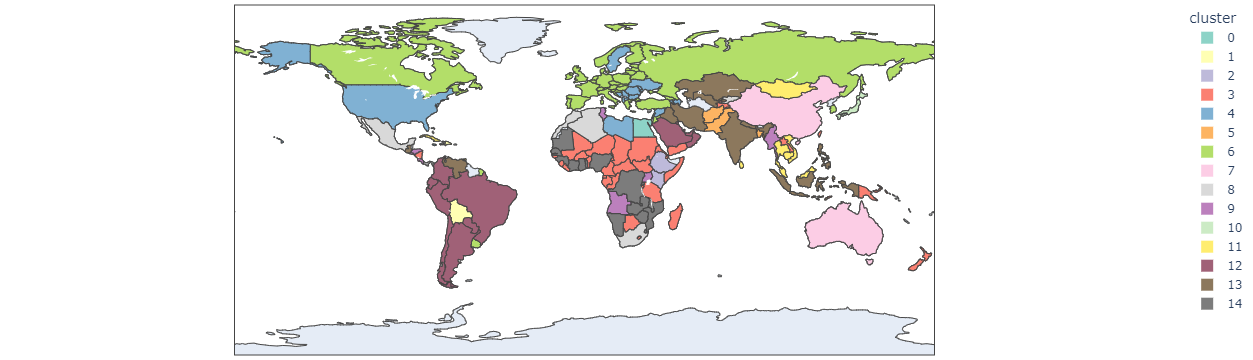

In [113]:
fig = px.choropleth(mapDF, locations="iso",
                    color="cluster", # lifeExp is a column of gapminder
                    hover_name="location", # column to add to hover information
                    color_discrete_sequence=px.colors.qualitative.Set3 + px.colors.qualitative.Antique[-3:]
                   )
fig.update_layout(margin=dict(l=5, r=5, t=5, b=5))
fig.show()

In [107]:
px.colors.qualitative.Light24[-15:]

['#EEA6FB',
 '#DC587D',
 '#D626FF',
 '#6E899C',
 '#00B5F7',
 '#B68E00',
 '#C9FBE5',
 '#FF0092',
 '#22FFA7',
 '#E3EE9E',
 '#86CE00',
 '#BC7196',
 '#7E7DCD',
 '#FC6955',
 '#E48F72']

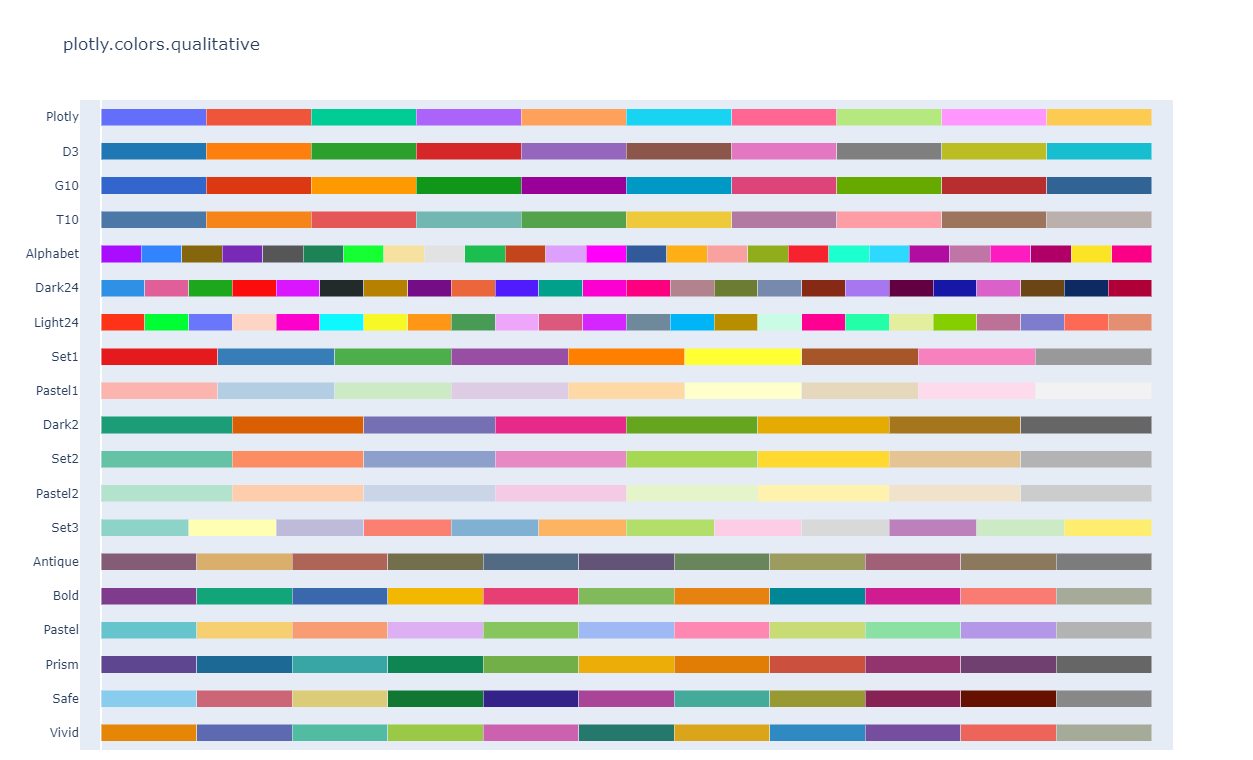

In [111]:
px.colors.qualitative.swatches()

# Border Information

In [107]:
borderDF = pd.read_csv('Data//borderData.csv')

In [108]:
convertISO = lambda x: codeMatching[x]

In [109]:
borders = {}
borderMatching = list(borderDF.groupby('country_code'))
for country in borderMatching:
    iso2 = country[0]
    for neighbor in country[1]['country_border_code']:
        if isinstance(neighbor, str):
            if codeMatching[iso2] in borders:
                borders[codeMatching[iso2]].append(codeMatching[neighbor])
            else:
                borders[codeMatching[iso2]] = [codeMatching[neighbor]]

In [110]:
countryIndexes = {}
for i in range(len(countries)):
    countryIndexes[countries[i]] = i

In [111]:
borderMatrix = [[0 for i in range(len(countries))] for j in range(len(countries))]
for countryISO in borders:
    if countryISO in ISOCodes:
        country = ISOCodes[countryISO]
        for neighborISO in borders[countryISO]:
            if neighborISO in ISOCodes:
                neighbor = ISOCodes[neighborISO]
                borderMatrix[countryIndexes[country]][countryIndexes[neighbor]] = 1
                borderMatrix[countryIndexes[neighbor]][countryIndexes[country]] = 1

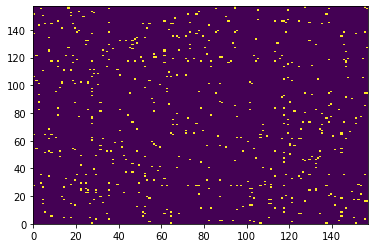

In [112]:
plt.pcolormesh(pd.DataFrame(borderMatrix))

# Capitals distance measurement

In [165]:
from geopy import distance

In [166]:
with open('Data//capitals.json') as f:
    capitalsData = json.load(f)

In [167]:
specialCountries = {'Republic of Congo':'Congo', 'Czech Republic':'Czechia', 'Democratic Republic of the Congo': 'Democratic Republic of Congo', 'Swaziland':'Eswatini',
                    'The Gambia':'Gambia', 'Macedonia':'North Macedonia', 'Timor-Leste':'Timor'}
for country in capitalsData:
    if country['CountryName'] in specialCountries:
        country['CountryName'] = specialCountries[country['CountryName']]

In [168]:
capitalsData = sorted(capitalsData, key=lambda d: d['CountryName']) 

In [169]:
capitals = []
for country in capitalsData:
    if country['CountryName'] in countries:
        capitals.append((country['CapitalLatitude'], country['CapitalLongitude']))
capitals[149] = (38.883333, -77.000000)

In [170]:
distancesCapitals = [[0 for i in range(len(countries))] for j in range(len(countries))]
for i in range(len(countries)):
    for j in range(i + 1, len(countries)):
        dist = distance.distance(capitals[i], capitals[j]).miles
        distancesCapitals[i][j] = dist
        distancesCapitals[j][i] = dist

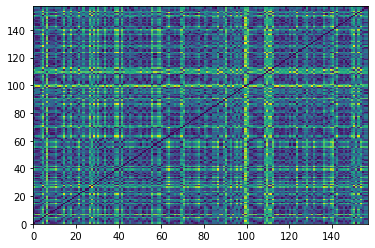

In [171]:
plt.pcolormesh(pd.DataFrame(distancesCapitals))

In [172]:
totalVariance = 0
for i in range(len(distancesCapitals)):
    for j in range(i + 1, len(distancesCapitals)):
        totalVariance += distancesCapitals[i][j]
withinClusterVariance = 0
for cluster in rankClusters:
    for i in range(len(cluster)):
        for j in range(i + 1,len(cluster)):
            withinClusterVariance += distancesCapitals[cluster[i]][cluster[j]]
betweenClusterVariance = totalVariance - withinClusterVariance

#### Ratio of Between cluster variance to total variance

In [173]:
betweenClusterVariance / totalVariance

0.9137020258608342

#### This result suggests that geography does have a substantial influence on a countries COVID-19 experience

# ANOVA

In [130]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [132]:
model = ols('value ~ C(variable)', data=pd.DataFrame(gdpClusters).T.melt()).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(variable),2.156303e+10,8.0,11.323127,2.284882e-12
Residual,3.427803e+10,144.0,NaN,NaN


#### Population Density

In [177]:
with open('Data//pop_density.json') as f:
    popDensityData = json.load(f)

In [178]:
specialCountries2 = {'DR Congo':'Democratic Republic of Congo', 'Ivory Coast':'Cote d\'Ivoire', 'Republic of the Congo':'Congo'}
for country in popDensityData:
    if country['country'] in specialCountries:
        country['country'] = specialCountries[country['country']]
    if country['country'] in specialCountries2:
        country['country'] = specialCountries2[country['country']]

In [179]:
popDensityData = sorted(popDensityData, key=lambda d: d['country']) 

In [195]:
popDensity = []
for country in popDensityData:
    if country['country'] in countries:
        popDensity.append(float(country['density']))
popDensity.insert(74, 159)

In [196]:
popDensityClusters = []
for cluster in rankClusters:
    PDCluster = [popDensity[x] for x in cluster]
    popDensityClusters.append(PDCluster)

In [198]:
model = ols('value ~ C(variable)', data=pd.DataFrame(popDensityClusters).T.melt()).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(variable),2.138612e+07,8.0,3.982575,0.000267
Residual,9.934357e+07,148.0,NaN,NaN


# Graph Visualization

In [206]:
import seaborn as sns

In [199]:
gdpDF['pop_density'] = popDensity

In [204]:
consolidatedDP = gdpDF.merge(mapDF, on='location')

(0.0, 1000.0)

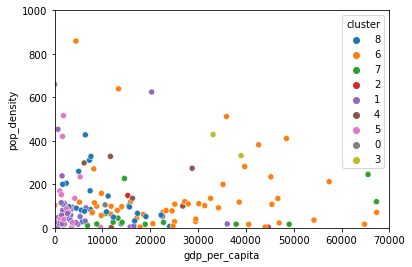

In [217]:
sns.scatterplot(x='gdp_per_capita', y='pop_density', data = consolidatedDP, hue = 'cluster')
plt.xlim(0, 70000)
plt.ylim(0,1000)

### Cluster Qualities

* Cluster 1 (Purple) - Very low GDP per capita and a range of population densities
* Cluster 6 (Orange) - Large range of GDP per capita, lower population density
* Cluster 7 (Green)  - Mostly between 10k - 20k GDP per capita and lower population densities